In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

# Load data
# base_path = "/home/tvanhout/oxides_ML/models/hyperparameter_optimization/augment"
# directory = "Set3/architecture_pool_heads/input_architecture_pool_heads_3"

base_path = "/home/tvanhout/oxides_ML/models/exclude_low_ads"
directory = "test1"

df_training     = pd.read_csv(os.path.join(base_path, directory , "training.csv"))
df_train_set    = pd.read_csv(os.path.join(base_path, directory , "train_set.csv")) 
df_test_set     = pd.read_csv(os.path.join(base_path, directory , "test_set.csv"))
df_val_set      = pd.read_csv(os.path.join(base_path, directory , "validation_set.csv"))
df_uq           = pd.read_csv(os.path.join(base_path, directory , "uq.csv"))

df_test_set[["Abs_error_eV"]].mean()

Abs_error_eV    0.493097
dtype: float64

## Performance metrics

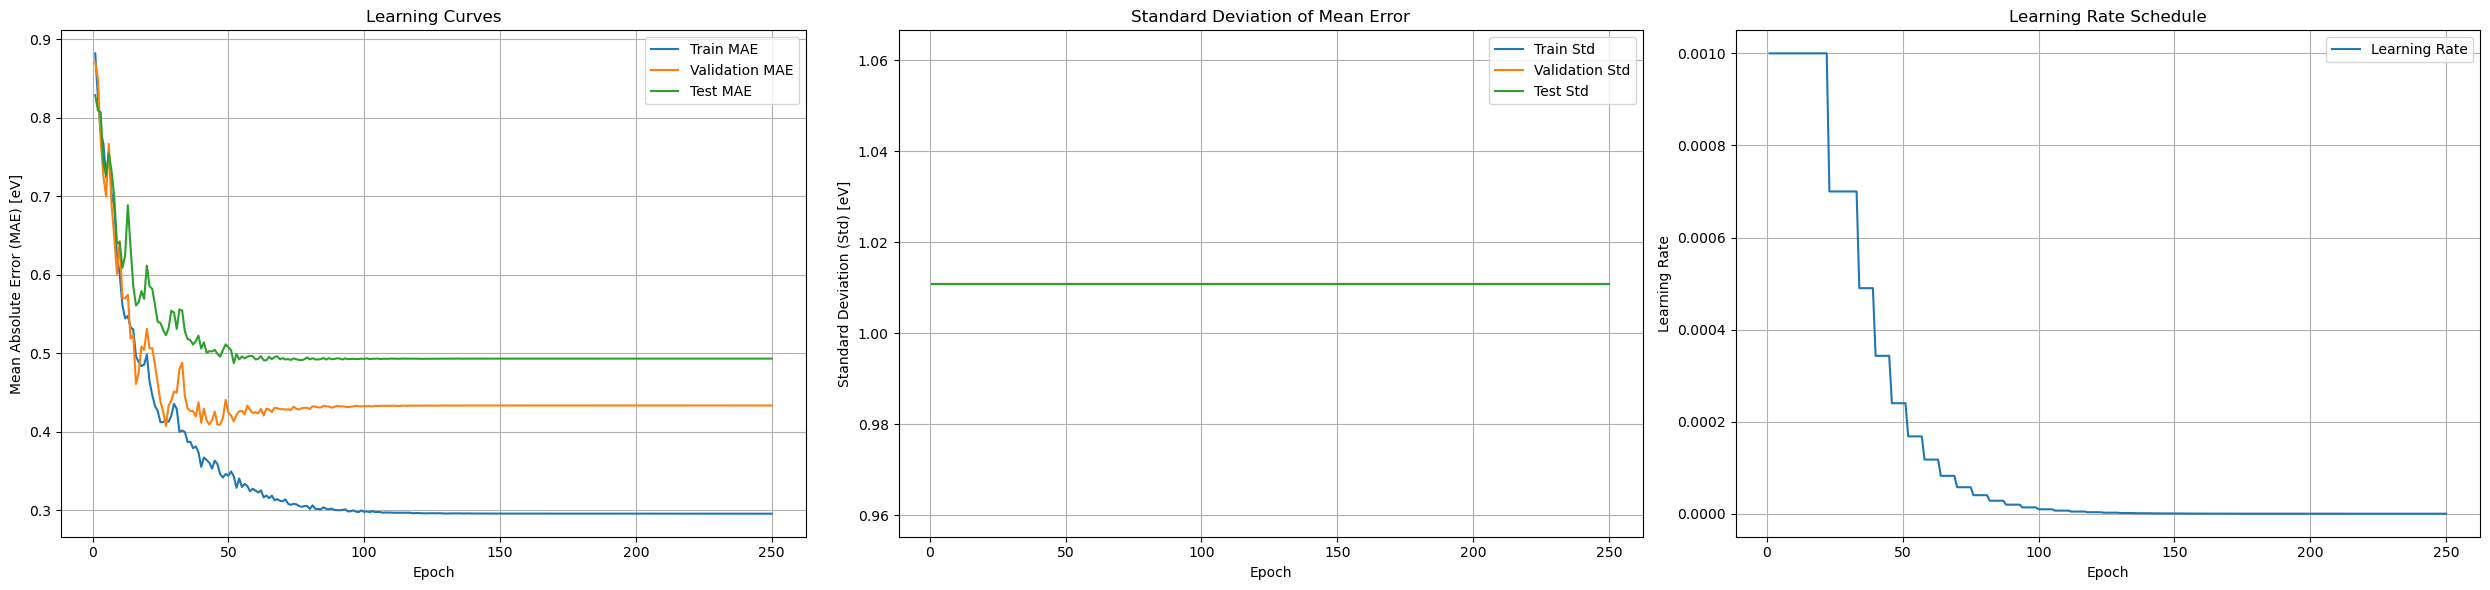

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(25, 6))

# Learning Curves (Train, Val, Test MAE)
axs[0].plot(df_training['Epoch'], df_training['Train_MAE_eV'], label='Train MAE')
axs[0].plot(df_training['Epoch'], df_training['Val_MAE_eV'], label='Validation MAE')
axs[0].plot(df_training['Epoch'], df_training['Test_MAE_eV'], label='Test MAE')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean Absolute Error (MAE) [eV]')
axs[0].set_title('Learning Curves')
axs[0].legend()
axs[0].grid(True)

# Standard Deviation of Predictions (Train, Val, Test Std)
axs[1].plot(df_training['Epoch'], df_training['Train_std_eV'], label='Train Std')
axs[1].plot(df_training['Epoch'], df_training['Val_std_eV'], label='Validation Std')
axs[1].plot(df_training['Epoch'], df_training['Test_std_eV'], label='Test Std')

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Standard Deviation (Std) [eV]')
axs[1].set_title('Standard Deviation of Mean Error')
axs[1].legend()
axs[1].grid(True)

# Learning Rate Schedule
axs[2].plot(df_training['Epoch'], df_training['Learning_Rate'], label='Learning Rate')

axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Learning Rate')
axs[2].set_title('Learning Rate Schedule')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


##  Evaluation of the test set

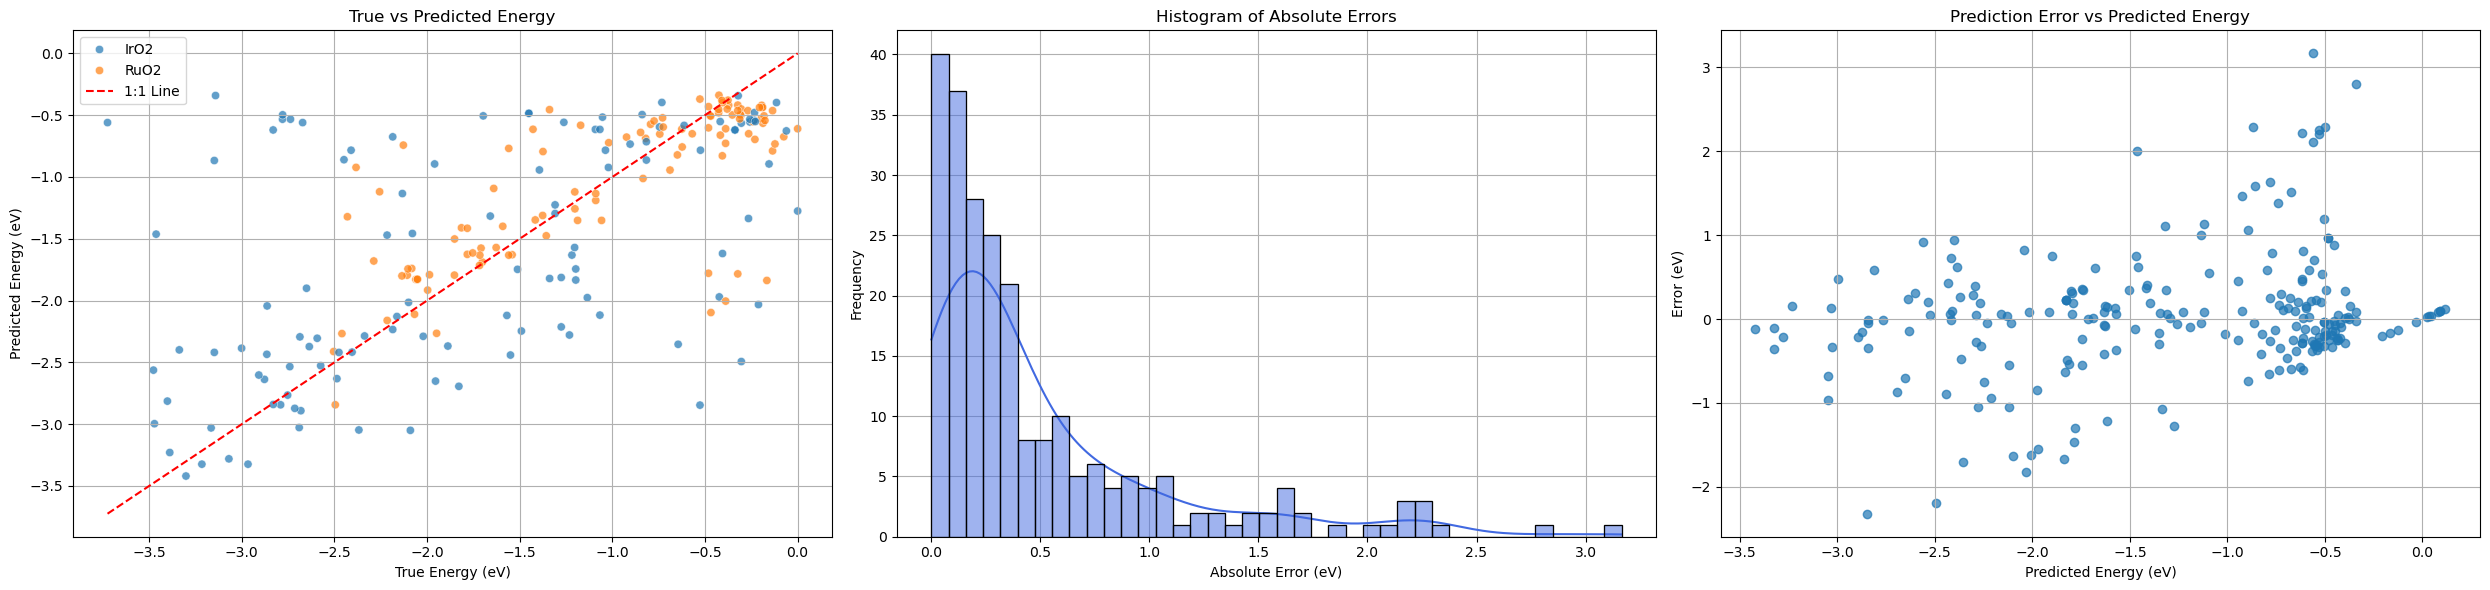

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(25, 6))  

# True vs. Predicted Energy Plot
sns.scatterplot(df_test_set, x='True_eV', y='Prediction_eV', alpha=0.7, hue= "Material", ax=axes[0])
axes[0].plot([min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             [min(df_test_set['True_eV']), max(df_test_set['True_eV'])], 
             'r--', label='1:1 Line')
axes[0].set_xlabel('True Energy (eV)')
axes[0].set_ylabel('Predicted Energy (eV)')
axes[0].set_title('True vs Predicted Energy')
axes[0].legend()
axes[0].grid(True)

# Histogram of Absolute Errors
sns.histplot(df_test_set['Abs_error_eV'], bins=40, kde=True, color='royalblue', ax=axes[1], zorder = 10)
axes[1].set_xlabel('Absolute Error (eV)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Absolute Errors')
axes[1].grid(True)

# Prediction Error vs. Predicted Energy
axes[2].scatter(df_test_set['Prediction_eV'], df_test_set['Error_eV'], alpha=0.7)
axes[2].set_xlabel('Predicted Energy (eV)')
axes[2].set_ylabel('Error (eV)')
axes[2].set_title('Prediction Error vs Predicted Energy')
axes[2].grid(True)

plt.tight_layout()
plt.show()


## Uncertainty quantification

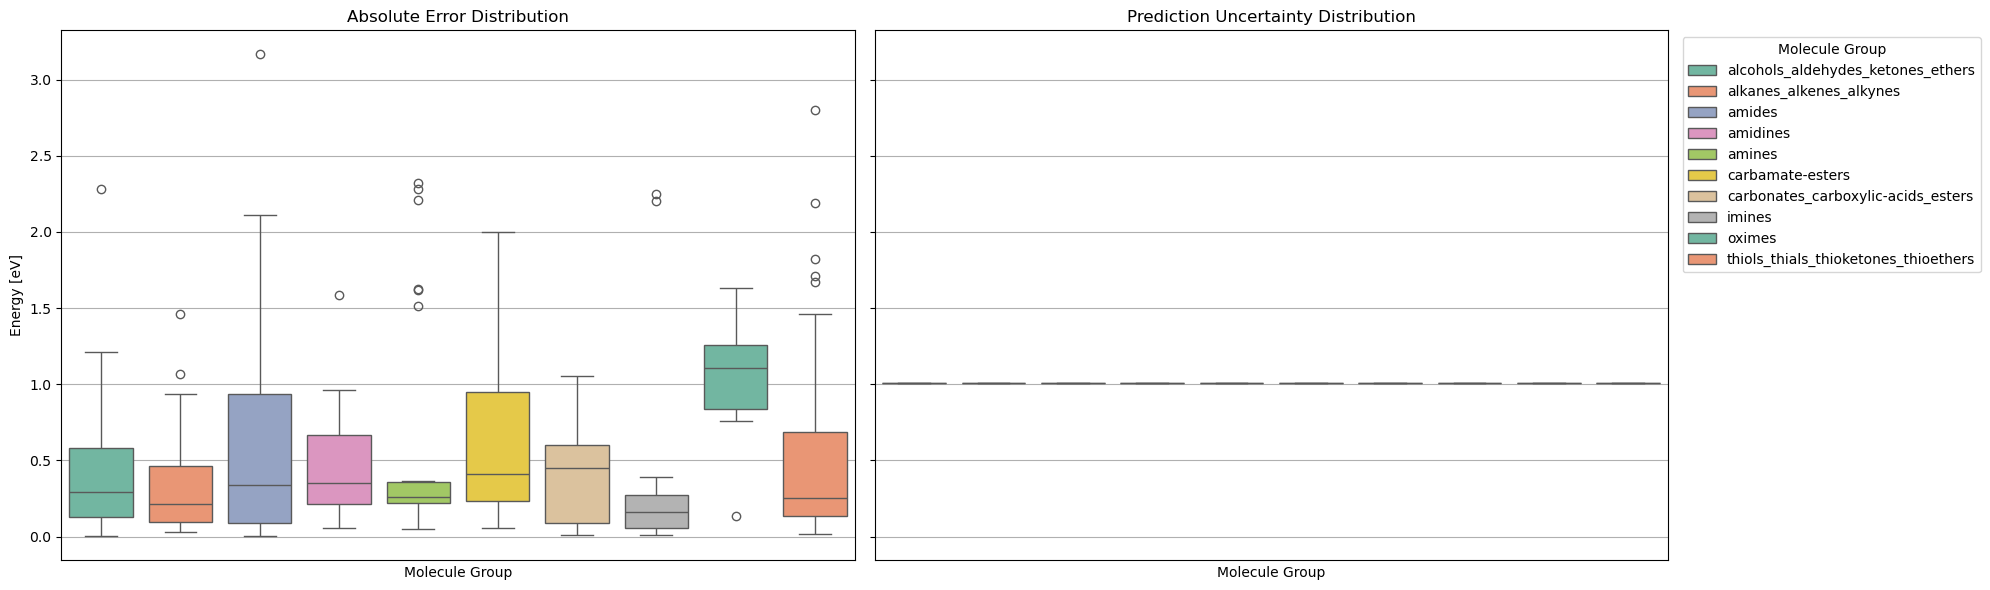

In [67]:
df_uq_sorted = df_uq.sort_values('molecule_group')

df_uq_sorted['abs_error'] = df_uq_sorted['error'].abs()
df_uq_sorted['uncertainty_width'] = df_uq_sorted['y_std']

# Create subplots with shared y-axis
fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

# First subplot: Absolute Error
sns.boxplot(data=df_uq_sorted, x='molecule_group', y='abs_error', hue='molecule_group', palette="Set2", legend=False, ax=axes[0])
axes[0].set_xlabel('Molecule Group')
axes[0].set_ylabel('Energy [eV]')
axes[0].set_title('Absolute Error Distribution')
axes[0].set_xticks([])
axes[0].grid(True)

# Second subplot: Uncertainty Width
sns.boxplot(data=df_uq_sorted, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette="Set2", legend=True, ax=axes[1])
axes[1].set_xlabel('Molecule Group')
axes[1].set_ylabel('')  # Shared y-label already on left
axes[1].set_title('Prediction Uncertainty Distribution')
axes[1].set_xticks([])
axes[1].grid(True)
axes[1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()


## Uncertainty Qualification per Surface

In [68]:
df_uq.groupby('material')['y_std'].mean()

material
IrO2    1.010933
RuO2    1.010933
Name: y_std, dtype: float64

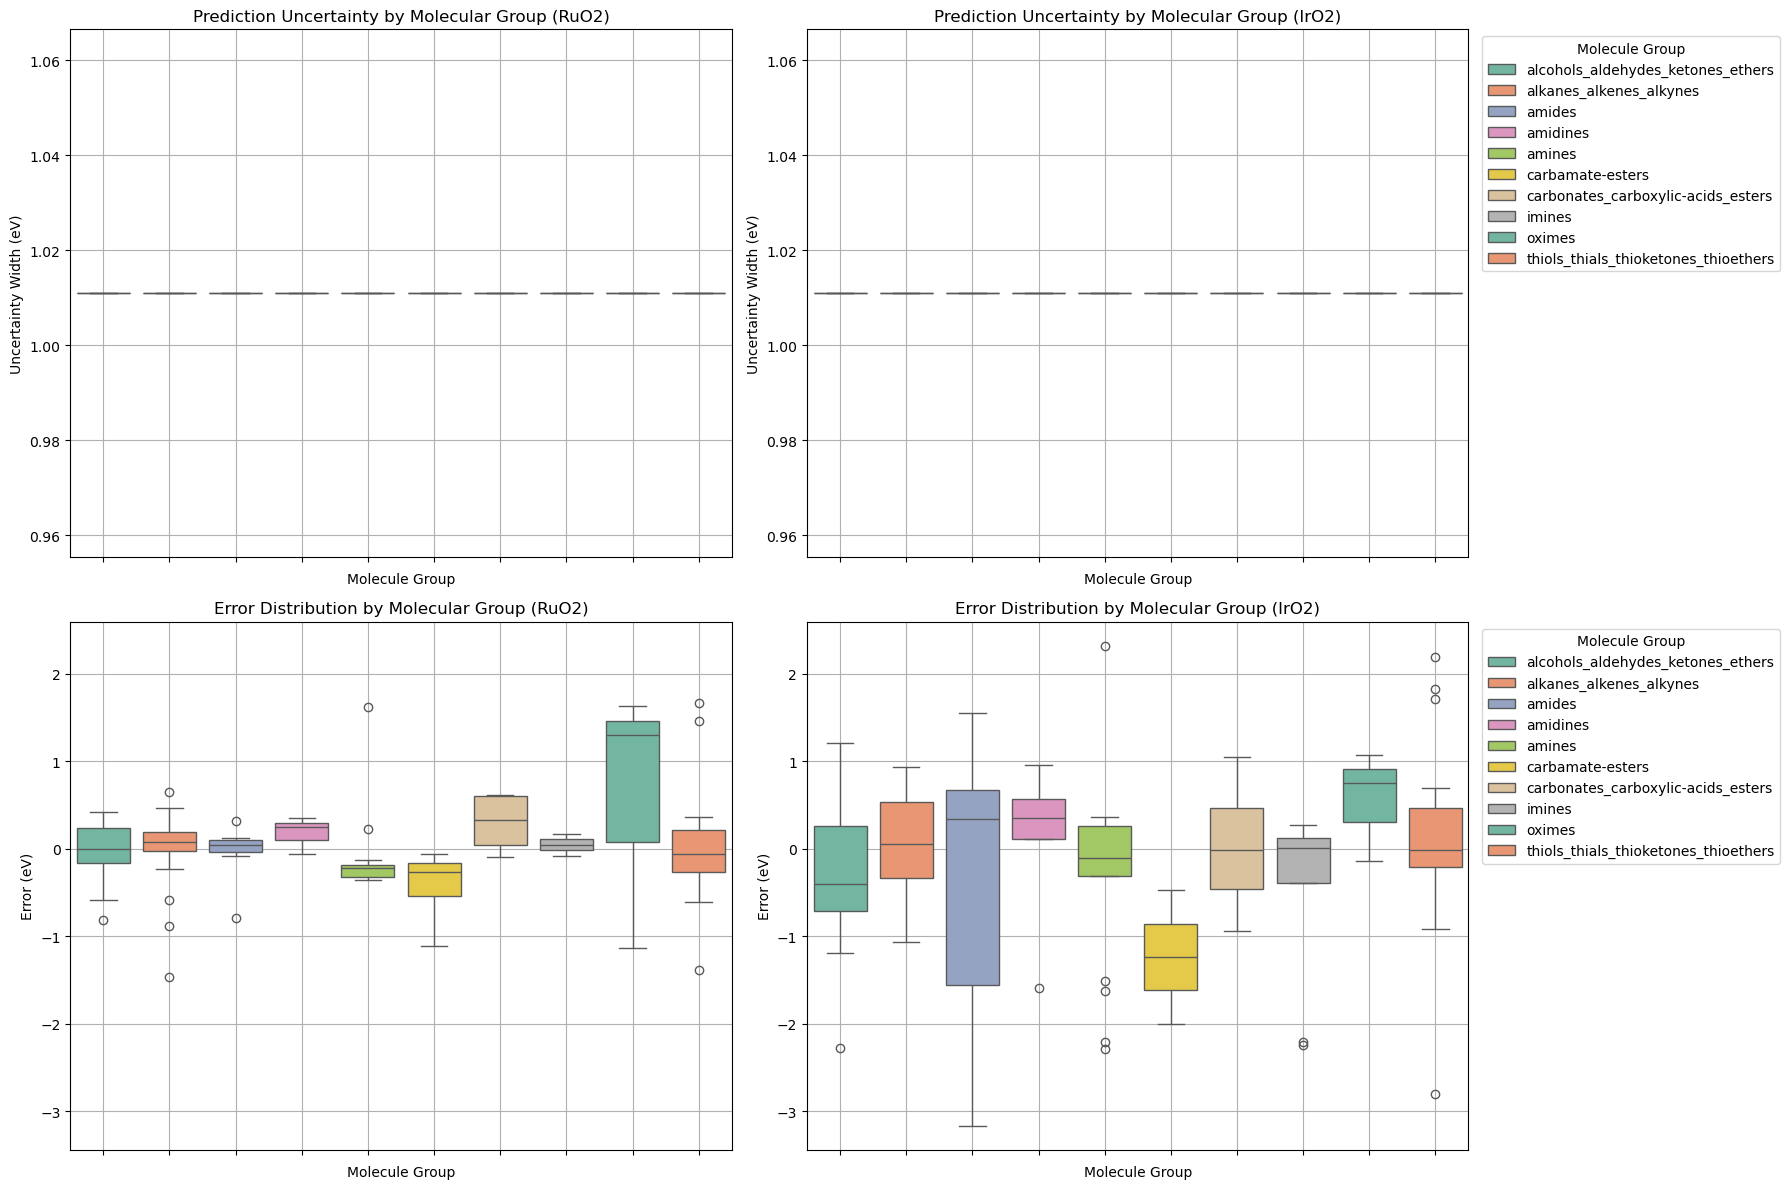

In [69]:
# Filter per material
df_ru = df_uq_sorted[df_uq_sorted['material'] == 'RuO2']
df_ir = df_uq_sorted[df_uq_sorted['material'] == 'IrO2']


# Create figure with two subplots
fig, axes = plt.subplots(2, 2, figsize=(18, 12))  # 1 row, 2 columns

# RuO2 plot
sns.boxplot(data=df_ru, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette='Set2', legend=False, ax=axes[0,0]
)
axes[0,0].set_title("Prediction Uncertainty by Molecular Group (RuO2)")
axes[0,0].set_xlabel("Molecule Group")
axes[0,0].set_ylabel("Uncertainty Width (eV)")
axes[0,0].set_xticklabels([])
axes[0,0].grid(True)
axes[0,0].sharey(axes[0,1])


# IrO2 plot
sns.boxplot(data=df_ir, x='molecule_group', y='uncertainty_width', hue='molecule_group', palette='Set2', legend=True, ax=axes[0,1])
axes[0,1].set_title("Prediction Uncertainty by Molecular Group (IrO2)")
axes[0,1].set_xlabel("Molecule Group")
axes[0,1].set_ylabel("Uncertainty Width (eV)")
axes[0,1].set_xticklabels([])
axes[0,1].grid(True)
axes[0,1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')

# RuO2 plot
sns.boxplot(data=df_ru, x='molecule_group', y='error', hue='molecule_group', palette='Set2', legend=False, ax=axes[1,0]
)
axes[1,0].set_title("Error Distribution by Molecular Group (RuO2)")
axes[1,0].set_xlabel("Molecule Group")
axes[1,0].set_ylabel("Error (eV)")
axes[1,0].set_xticklabels([])
axes[1,0].grid(True)
axes[1,0].sharey(axes[1,1])


# IrO2 plot
sns.boxplot(data=df_ir, x='molecule_group', y='error', hue='molecule_group', palette='Set2', legend=True, ax=axes[1,1])
axes[1,1].set_title("Error Distribution by Molecular Group (IrO2)")
axes[1,1].set_xlabel("Molecule Group")
axes[1,1].set_ylabel("Error (eV)")
axes[1,1].set_xticklabels([])
axes[1,1].grid(True)
axes[1,1].legend(title='Molecule Group', bbox_to_anchor=(1.01, 1), loc='upper left')



plt.tight_layout()
plt.show()


In [70]:
df_uq.sort_values(["y_true"], ascending=True).head(15)

,formula,material,surface,molecule_group,molecule,y_true,y_mean,error,y_std,y_min,y_max,in_interval,norm_res
135,C2H5Ir40NO81,IrO2,110.0,amides,Acetamide,-3.725091,-0.560232,-3.164858,1.010933,-2.541661,1.421196,False,-3.130631
109,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-3.477344,-2.563331,-0.914013,1.010933,-4.544760,-0.581902,True,-0.904128
158,CH3Ir40NO82,IrO2,110.0,carbamate-esters,Carbamic-acid,-3.471884,-2.996881,-0.475003,1.010933,-4.978309,-1.015452,True,-0.469866
180,CH3Ir40NO82,IrO2,110.0,carbamate-esters,Carbamic-acid,-3.462773,-1.462989,-1.999785,1.010933,-3.444418,0.518440,False,-1.978157
33,C2H4Ir40O82,IrO2,110.0,carbonates_carboxylic-acids_esters,Acetic-acid,-3.402022,-2.814081,-0.587941,1.010933,-4.795509,-0.832652,True,-0.581583
168,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,-3.389266,-3.229953,-0.159313,1.010933,-5.211381,-1.248524,True,-0.157590
9,CH2Ir40O82,IrO2,110.0,carbonates_carboxylic-acids_esters,Formic-acid,-3.337725,-2.399402,-0.938323,1.010933,-4.380831,-0.417973,True,-0.928176
198,C2H5Ir40NO80,IrO2,110.0,imines,N-methylmethanimine,-3.301773,-3.420274,0.118501,1.010933,-5.401703,-1.438845,True,0.117219
21,CH4Ir40N2O80,IrO2,110.0,amidines,Formimidamide,-3.215866,-3.324263,0.108397,1.010933,-5.305691,-1.342834,True,0.107224
118,CH3Ir40NO81,IrO2,110.0,oximes,Formaldoxime,-3.166023,-3.030703,-0.135320,1.010933,-5.012132,-1.049274,True,-0.133857


In [71]:
df_uq.sort_values(["y_std"], ascending=False).head(20)

,formula,material,surface,molecule_group,molecule,y_true,y_mean,error,y_std,y_min,y_max,in_interval,norm_res
0,C3H7Ir40NO80,IrO2,110.0,imines,Propan-2-imine,-2.790898,-2.843865,0.052968,1.010933,-4.825294,-0.862437,True,0.052395
1,C2H5Ir40NO81,IrO2,110.0,amides,Acetamide,-2.133575,-1.134468,-0.999108,1.010933,-3.115896,0.846961,True,-0.988303
2,C3H9Ir40NO80,IrO2,110.0,amines,Propan-2-amine,-2.741279,-2.534832,-0.206447,1.010933,-4.516261,-0.553404,True,-0.204214
3,C2H5N,NaN,NaN,imines,Ethanimine,0.000000,0.022617,-0.022617,1.010933,-1.958812,2.004045,True,-0.022372
4,C2H6Ir40O80,IrO2,110.0,alkanes_alkenes_alkynes,Ethane,-2.079480,-1.457486,-0.621994,1.010933,-3.438915,0.523943,True,-0.615267
5,C3H6O80Ru40,RuO2,110.0,alkanes_alkenes_alkynes,Propylene,-0.187497,-0.565349,0.377852,1.010933,-2.546778,1.416079,True,0.373766
6,CH3Ir40NO81,IrO2,110.0,amides,Formamide,-1.828715,-2.694288,0.865572,1.010933,-4.675716,-0.712859,True,0.856211
7,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Dimethylsulfane,-1.309339,-1.226065,-0.083274,1.010933,-3.207494,0.755363,True,-0.082373
8,C3H9Ir40NO80,IrO2,110.0,amines,Propan-2-amine,-2.185714,-0.675536,-1.510178,1.010933,-2.656964,1.305893,True,-1.493846
9,CH2Ir40O82,IrO2,110.0,carbonates_carboxylic-acids_esters,Formic-acid,-3.337725,-2.399402,-0.938323,1.010933,-4.380831,-0.417973,True,-0.928176


In [72]:
df_uq.sort_values(["error"], ascending=False).head(15)

,formula,material,surface,molecule_group,molecule,y_true,y_mean,error,y_std,y_min,y_max,in_interval,norm_res
36,C3H9Ir40NO80,IrO2,110.0,amines,Propan-2-amine,-0.527265,-2.846465,2.319200,1.010933,-4.827894,-0.865037,False,2.294119
76,C2H6Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Dimethylsulfane,-0.304123,-2.493956,2.189833,1.010933,-4.475384,-0.512527,False,2.166150
73,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-0.211618,-2.032640,1.821022,1.010933,-4.014069,-0.051211,True,1.801329
89,C3H8Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Propane-2-thiol,-0.645100,-2.354157,1.709057,1.010933,-4.335586,-0.372728,True,1.690574
31,C2H6O80Ru40S,RuO2,110.0,thiols_thials_thioketones_thioethers,Dimethylsulfane,-0.166147,-1.837676,1.671529,1.010933,-3.819105,0.143752,True,1.653452
190,CH3NO81Ru40,RuO2,110.0,oximes,Formaldoxime,-0.468205,-2.097220,1.629014,1.010933,-4.078649,-0.115791,True,1.611397
200,C3H9NO80Ru40,RuO2,110.0,amines,Propan-2-amine,-0.388596,-2.004857,1.616261,1.010933,-3.986285,-0.023428,True,1.598781
78,C2H5Ir40NO81,IrO2,110.0,amides,Acetamide,-0.423029,-1.970849,1.547820,1.010933,-3.952277,0.010580,True,1.531081
213,C2H6O80Ru40S,RuO2,110.0,thiols_thials_thioketones_thioethers,Ethanethiol,-0.323241,-1.784525,1.461284,1.010933,-3.765954,0.196904,True,1.445481
221,CH3NO81Ru40,RuO2,110.0,oximes,Formaldoxime,-0.481381,-1.779285,1.297904,1.010933,-3.760714,0.202144,True,1.283868


In [73]:
outliers = df_uq[df_uq["formula"] == "CH4Ir40O80S"]
outliers

,formula,material,surface,molecule_group,molecule,y_true,y_mean,error,y_std,y_min,y_max,in_interval,norm_res
113,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,-2.486884,-2.632344,0.145460,1.010933,-4.613773,-0.650916,True,0.143887
133,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,-3.070039,-3.281077,0.211038,1.010933,-5.262505,-1.299648,True,0.208756
197,CH4Ir40O80S,IrO2,110.0,thiols_thials_thioketones_thioethers,Methanethiol,-3.142078,-0.341403,-2.800675,1.010933,-2.322832,1.640026,False,-2.770386
